In [2]:
from theano import tensor as T
import theano
import lasagne
import PIL
import numpy as np
import os
from IPython.display import Image, display
from matplotlib import pyplot as plt
import sys
import urllib
from tqdm import tqdm_notebook
%matplotlib inline

In [29]:
sys.path.append("../")
import vk

In [24]:
def download_train(size=200000):
    urls = []
    last_id = 1
    _id = 1
    while len(urls) < number_of_user:
        while True:
            user_ids = vk.get_friends(_id)
            if len(user_ids) == 0:
                _id = last_id
            else:
                break

        urls = urls + [x["photo_200"]  for x in vk.get_users_info(user_ids, field_list=["photo_200"]).values() if "photo_200" in x.keys()]

        last_id = _id
        _id = np.random.choice(user_ids)
    for url in tqdm_notebook(urls):
        urllib.request.urlretrieve(url, "Test_Images/{0}".format(url.split("/")[-1]))

In [19]:
def memory_iter(path_name, batch_size=100):
    file_list = np.array(os.listdir(path_name))
    path_name = path_name.strip("/")
    for start_idx in range(0, len(file_list)-batch_size+1, batch_size):
        data = []
        ids = []
        for file in file_list[start_idx:start_idx+batch_size]:
            pic = np.array(PIL.Image.open("{0}/{1}".format(path_name, file)))
            if len(pic.shape) != 3 :
                #data.append(np.array([pic[:,:], pic[:,:], pic[:,:]]))
                continue
            else:
                data.append(np.array([pic[:,:,0], pic[:,:,1], pic[:,:,2]]))
            ids.append(file.split(".")[0])
        yield np.array(data), np.array(ids)

## Train

In [4]:
input_X = T.tensor4("Inputs")

In [5]:
######### First net 
######### Loss ~ 1800
input_layer = lasagne.layers.InputLayer((None, 3, 200, 200), input_X)

first_d = lasagne.layers.DenseLayer(input_layer, 1000)
second_d = lasagne.layers.DenseLayer(first_d, 500)

vector_layer = lasagne.layers.DenseLayer(second_d, 200)

third_d = lasagne.layers.DenseLayer(vector_layer, 500)
fourth_d = lasagne.layers.DenseLayer(third_d, 1000)

output = lasagne.layers.DenseLayer(fourth_d, 200*200)
final = lasagne.layers.ReshapeLayer(output, [[0], 1, 200, 200])

In [7]:
restored = lasagne.layers.get_output(final)
weigths = lasagne.layers.get_all_params(final)

loss = lasagne.objectives.squared_error(input_X, restored).mean()
updates = lasagne.updates.adam(loss, weigths)

vector = lasagne.layers.get_output(vector_layer)

In [8]:
train_func = theano.function([input_X], [loss], updates=updates)
predict_func = theano.function([input_X], [restored])
vector_func = theano.function([input_X], [vector])

In [25]:
EPOCH = 150

for epoch in range(EPOCH):
    loss = 0
    counter = 0
    for X, ids in memory_iter("Train_Images/", 200):
        
        loss += train_func(X)[0]
        counter += 1
    print("Epoch:{0} Loss:{1}".format(epoch, loss/counter))

Epoch:0 Loss:3880.9553740888546
Epoch:1 Loss:3646.743845734514
Epoch:2 Loss:3611.340783110876
Epoch:3 Loss:3651.7154582658336
Epoch:4 Loss:3475.3983106650203
Epoch:5 Loss:3375.499836747137
Epoch:6 Loss:3292.676609587154
Epoch:7 Loss:3233.2845390825505
Epoch:8 Loss:3210.8102472339124
Epoch:9 Loss:3147.7718037530703
Epoch:10 Loss:3062.275825155809
Epoch:11 Loss:3017.9079431320847
Epoch:12 Loss:3002.546309805508
Epoch:13 Loss:2978.3319087338314
Epoch:14 Loss:3015.6960542371876
Epoch:15 Loss:2888.2087620242896
Epoch:16 Loss:2872.975840229894
Epoch:17 Loss:2880.394318328141
Epoch:18 Loss:2866.2081758300105
Epoch:19 Loss:2855.168089386926
Epoch:20 Loss:2857.532931346889
Epoch:21 Loss:2850.8474063565627
Epoch:22 Loss:2843.0791527600886
Epoch:23 Loss:2840.531259413156
Epoch:24 Loss:2847.639396988184
Epoch:25 Loss:2826.166214592835
Epoch:26 Loss:2823.521416548106
Epoch:27 Loss:2796.8965733967475
Epoch:28 Loss:2776.819681759378
Epoch:29 Loss:2824.5685020611677
Epoch:30 Loss:2803.0397982010836
Ep

KeyboardInterrupt: 

In [27]:
params = np.array(lasagne.layers.get_all_param_values(final))

In [28]:
params.dump("Weights/second_weights.npy")

## Demonstration

In [30]:
test_ids = [278384858, 50210325, 55783291, 69153571]
info = vk.get_users_info(test_ids, ["photo_200"])
for ind, user in enumerate(info.values()):
    urllib.request.urlretrieve(user["photo_200"], "Test_Images/{0}.png".format(ind))

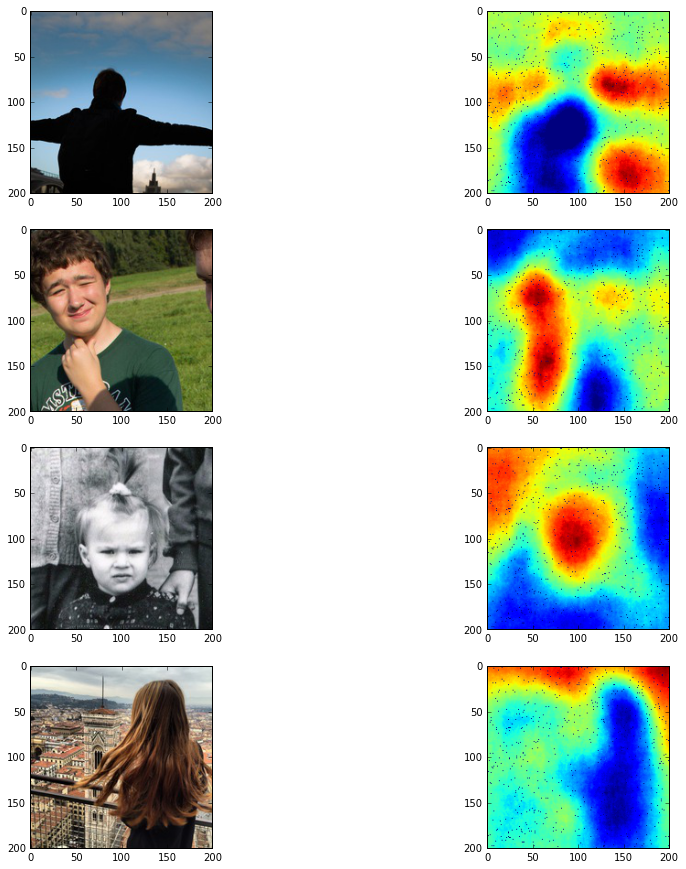

In [40]:
data = []
pics = []
for file in os.listdir("Test_Images/"):
    pic = np.array(PIL.Image.open("Test_Images/{0}".format(file)))
    pics.append(pic)
    data.append(np.array([pic[:,:,0], pic[:,:,1], pic[:,:,2]]))
    
data = np.array(data)
pics = np.array(pics)

prediction = predict_func(data)

f, arr = plt.subplots(nrows=len(prediction[0]), ncols=2, figsize=(15,15))

for ind, pic in enumerate(prediction[0]):
    arr[ind][0].imshow(pics[ind])
    arr[ind][1].imshow(pic[0])

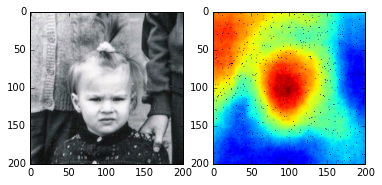

In [171]:
pics = os.listdir("Test_Images/")
pic = np.array(PIL.Image.open("Test_Images/{0}".format(np.random.choice(pics))))
pic_ = np.array([pic[:,:,0], pic[:,:,1], pic[:,:,2]])
pred = predict_func([pic_])[0][0][0]
f, arr = plt.subplots(ncols=2)
arr[0].imshow(pic)
arr[1].imshow(pred)

In [172]:
PIL.Image.fromarray(pred).show()

## Simularity test

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
for images, ids in memory_iter("Train_Images/", 300):
    vectors = vector_func(images)[0]
    for ind, vector in enumerate(vectors):
        vector.dump("Vectors/{0}.vec".format(ids[ind]))

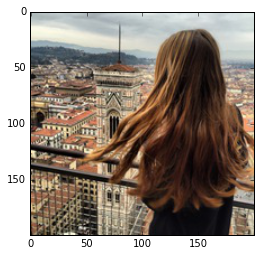

In [218]:
test_pic_orig = np.array(PIL.Image.open("Test_Images/0.png"))
test_pic = np.array([test_pic_orig[:,:,0], test_pic_orig[:,:,1], test_pic_orig[:,:,1]])
test_vec = vector_func([test_pic])[0][0]
plt.imshow(test_pic_orig)

In [219]:
data = []
users = {}
for ind, vec_name in enumerate(os.listdir("Vectors/")):
    data.append(np.load("Vectors/{0}".format(vec_name)))
    users[ind] = vec_name.split(".")[0]
data = np.array(data)

In [220]:
sims = cosine_similarity(test_vec, data)[0]
sim_dict = {y:users[x] for x,y in enumerate(sims)}
sims = sorted(sims, reverse=True)

/home/mdm/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


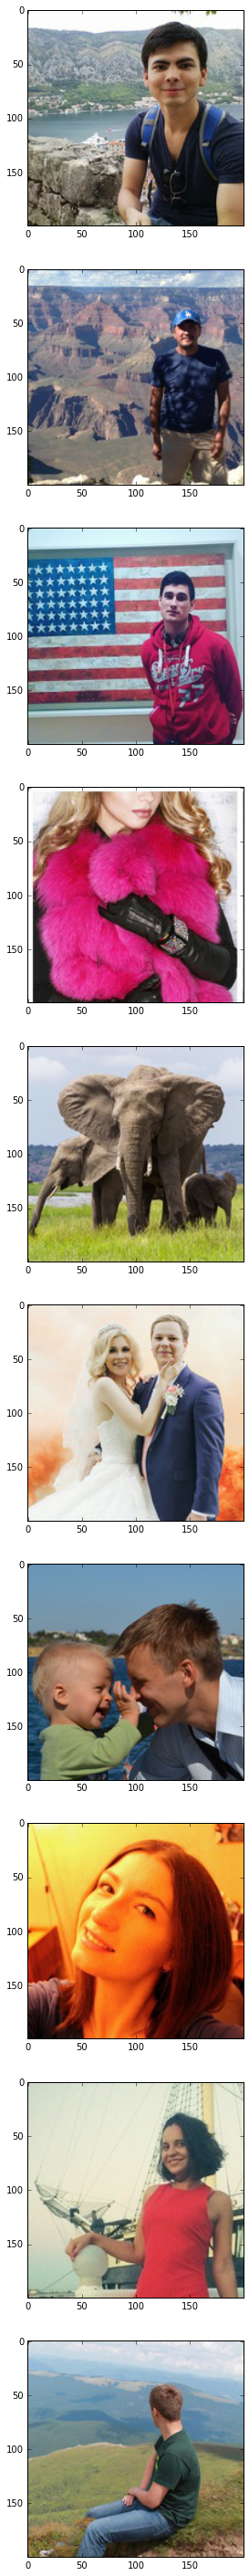

In [221]:
images = []
for sim in sims[:10]:
    images.append(PIL.Image.open("Train_Images/{0}.jpg".format(sim_dict[sim])))
f, arr = plt.subplots(nrows=10, figsize=(50,50))
for i in range(10):
    arr[i].imshow(images[i])

## Clustering test

In [161]:
vectors = []
for vec in os.listdir("Vectors/")[:5000]:
    vectors.append(np.load("Vectors/{0}".format(vec)))

In [162]:
from sklearn.manifold import TSNE 
tsne = TSNE()
result = tsne.fit_transform(vectors)

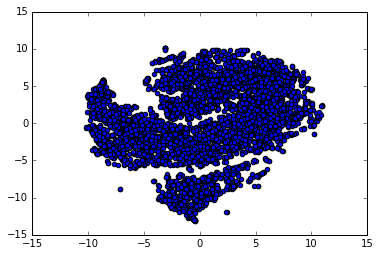

In [166]:
plt.scatter([x[0] for x in result], [x[1] for x in result])

## Paintings

In [211]:
paintings = []
colors = []
for painting in os.listdir("Paintings/"):
    if painting.split(".")[0].split("_")[0] == "shishkin":
        colors.append("green")
    else:
        colors.append("blue")
    paint = np.array(PIL.Image.open("Paintings/{0}".format(painting)).resize((200, 200)))
    paintings.append(np.array([paint[:,:,0], paint[:,:,1], paint[:,:,2]]))

In [212]:
vectors = vector_func(paintings)[0]
prepared = tsne.fit_transform(vectors)

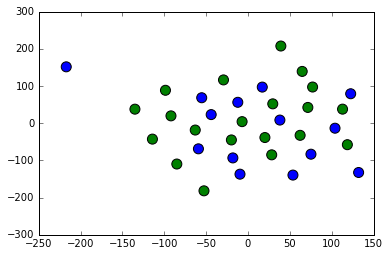

In [215]:
plt.scatter([x[0] for x in prepared], [x[1] for x in prepared], c=colors, s=100)